# ECMWF Tropical Cyclone Data Extractor - LATEST STORM Example

The extractor downloads tropical cyclone track BUFR files from ECMWF's Dissemination (DISS) system at https://essential.ecmwf.int/. It provides dynamic access to forecast data based on date/time parameters.

## Download

In [16]:
from ecmwf_tc_data_downloader import download_tc_data, list_available_storms

import os
import shutil
import glob

### List available storms

In [17]:
storms = list_available_storms(limit=1)

print(f"Found {len(storms)} unique storms:")
for i, storm in enumerate(storms, 1):
    print(f"{i:2d}. {storm['storm_name']:8s} at {storm['latitude']:12s}, {storm['longitude']:12s} (Forecast: {storm['forecast_time']})")

Found 1 forecast dates
   Found 4 tropical cyclone track files
Found 0 unique storms
Found 0 unique storms:


### Download latest forecasts

In [18]:
# Clear the tc_latest directory before processing
if os.path.exists('tc_latest'):
    shutil.rmtree('tc_latest')
    print("Cleared tc_latest directory")

# Ensure tc_latest directory exists
os.makedirs('tc_latest', exist_ok=True)

Cleared tc_latest directory


In [19]:
results = download_tc_data(limit=1, output_dir='tc_latest')

Found 1 forecast dates
Processing 1 forecast(s)

   Found 4 tropical cyclone track files
   ... and 1 more storms
   Downloaded: A_JSXX01ECMF180600_C_ECMP_20250918060000_tropical_cyclone_track_GABRIELLE_-49p8degW_19p7degN_bufr4.bin (1,528 bytes)
   Downloaded: A_JSXX02ECMF180600_C_ECMP_20250918060000_tropical_cyclone_track_MITAG_118p8degE_19p8degN_bufr4.bin (1,528 bytes)
   Downloaded: A_JSXX03ECMF180600_C_ECMP_20250918060000_tropical_cyclone_track_23W_132p7degE_15p2degN_bufr4.bin (1,528 bytes)
   Downloaded: A_JSXX04ECMF180600_C_ECMP_20250918060000_tropical_cyclone_track_24W_164p5degE_23p4degN_bufr4.bin (1,528 bytes)

Summary:
   Successfully downloaded: 4 files
   Failed downloads: 0 files
   Files saved to: tc_latest/


## Extract

In [20]:
from ecmwf_tc_data_extractor import extract_tc_data, extract_tc_data_from_file

In [21]:
# Get files from tc_latest directory, preferring named storms over numeric identifiers
bin_files = glob.glob('tc_latest/*.bin')
if not bin_files:
    raise FileNotFoundError("No .bin files found in tc_latest directory")

# Prefer files with named storms (not just numeric identifiers like 24W, 23W)
# Look for files that have a name after "tropical_cyclone_track_" that doesn't start with a number
named_storm_files = []
numeric_storm_files = []

for file in bin_files:
    # Extract the part after "tropical_cyclone_track_"
    if 'tropical_cyclone_track_' in file:
        after_track = file.split('tropical_cyclone_track_')[1]
        storm_name = after_track.split('_')[0]  # Get the first part before the next underscore

        # Check if it's a named storm (doesn't start with a number)
        if not storm_name[0].isdigit():
            named_storm_files.append(file)
        else:
            numeric_storm_files.append(file)

# Prefer named storms, fall back to numeric if no named storms available
if named_storm_files:
    filename = named_storm_files[0]
    storm_name = filename.split('tropical_cyclone_track_')[1].split('_')[0]
    print(f"Selected named storm file: {storm_name} - {filename}")
else:
    filename = numeric_storm_files[0] if numeric_storm_files else bin_files[0]
    storm_name = filename.split('tropical_cyclone_track_')[1].split('_')[0] if 'tropical_cyclone_track_' in filename else "unknown"
    print(f"No named storms found, using: {storm_name} - {filename}")


Selected named storm file: GABRIELLE - tc_latest/A_JSXX01ECMF180600_C_ECMP_20250918060000_tropical_cyclone_track_GABRIELLE_-49p8degW_19p7degN_bufr4.bin


In [22]:
# Extract using the main function (saves to CSV automatically)
result = extract_tc_data_from_file(filename, output_dir='tc_latest')

Extracting tropical cyclone data from: tc_latest/A_JSXX01ECMF180600_C_ECMP_20250918060000_tropical_cyclone_track_GABRIELLE_-49p8degW_19p7degN_bufr4.bin
Stage 1: Reading BUFR file structure...
Storm: 07L, Ensemble Members: 1
Forecast Base Time: 2025-09-18 06:00:00
Number of Subsets: 1
Stage 2: Extracting data arrays from BUFR Section 4...
Array sizes:
  latitude: 33
  longitude: 33
  significance: 33
    Unique values: [1 3 5]
  time_period: 15
  pressure: 16
  wind_speed: 16
  wind_threshold: 48
    Unique values: [18 26 33]
  bearing: 384
    Unique values: [  0.  90. 180. 270.]

Stage 3: Mapping wind radii data to positions...
Processing 33 positions...
Mapping wind radii data using systematic array association...

Stage 4: Structuring data and creating comprehensive records...
Total records created: 33
Records with coordinates: 33
Records with wind radii data: 33

Wind threshold distribution:
  35 knots: 11 records
  51 knots: 11 records
  64 knots: 11 records

Bearing distribution:

### Extract data without saving to CSV

In [23]:
df = extract_tc_data(filename, verbose=False)

print(f"Extracted {len(df)} records")
print(f"Columns: {list(df.columns)}")
print(f"Sample data:")
print(df.head())

Extracted 33 records
Columns: ['storm_id', 'ensemble_member', 'forecast_step_hours', 'datetime', 'significance_code', 'position_type', 'latitude', 'longitude', 'pressure_pa', 'pressure_hpa', 'wind_speed_ms', 'wind_speed_knots', 'wind_threshold_ms', 'wind_threshold_knots', 'bearing_degrees', 'max_radius_km', 'array_index', 'has_wind_radii']
Sample data:
  storm_id  ensemble_member  forecast_step_hours            datetime  \
0      07L               52                    6 2025-09-18 12:00:00   
1      07L               52                    6 2025-09-18 12:00:00   
2      07L               52                   12 2025-09-18 18:00:00   
3      07L               52                   12 2025-09-18 18:00:00   
4      07L               52                   18 2025-09-19 00:00:00   

   significance_code position_type  latitude  longitude  pressure_pa  \
0                  1  storm_center      19.7      -49.8     100300.0   
1                  5    wind_radii      19.7      -50.0     100300.0

## Explore

In [24]:
from ecmwf_tc_data_explorer import (
    load_tc_data,
    calculate_wind_radii_from_points,
    create_track_visualization,
    create_wind_field_visualization,
    create_data_availability_visualization,
    create_wind_radii_spatial_plot,
    create_wind_radii_direction_plot
)

In [25]:
# Load the extracted data - find the CSV file automatically
csv_files = glob.glob('tc_latest/*_extracted.csv')
if not csv_files:
    raise FileNotFoundError("No extracted CSV files found in tc_latest directory")

csv_file = csv_files[0]
print(f"Loading data from: {csv_file}")

# Load data
df = load_tc_data(csv_file)

# Calculate wind radii
df, radii_df = calculate_wind_radii_from_points(df)

Loading data from: tc_latest/A_JSXX01ECMF180600_C_ECMP_20250918060000_tropical_cyclone_track_GABRIELLE_-49p8degW_19p7degN_bufr4_extracted.csv
Total records loaded: 33
Columns in dataset: 18

Data quality summary:
  storm_id: 33/33 values (100.0%)
  ensemble_member: 33/33 values (100.0%)
  forecast_step_hours: 33/33 values (100.0%)
  datetime: 33/33 values (100.0%)
  position_type: 33/33 values (100.0%)
  latitude: 33/33 values (100.0%)
  longitude: 33/33 values (100.0%)
  wind_speed_knots: 33/33 values (100.0%)
  wind_threshold_knots: 33/33 values (100.0%)
  bearing_degrees: 33/33 values (100.0%)
  has_wind_radii: 33/33 values (100.0%)

Wind radii analysis:
  Records with wind radii flags: 33
  Records with coordinates: 33
  Records with wind thresholds: 33
  Records with bearings: 33
Calculated radii for 33 wind points
Radius range: 0.0 to 1700.8 km


### Data Availability

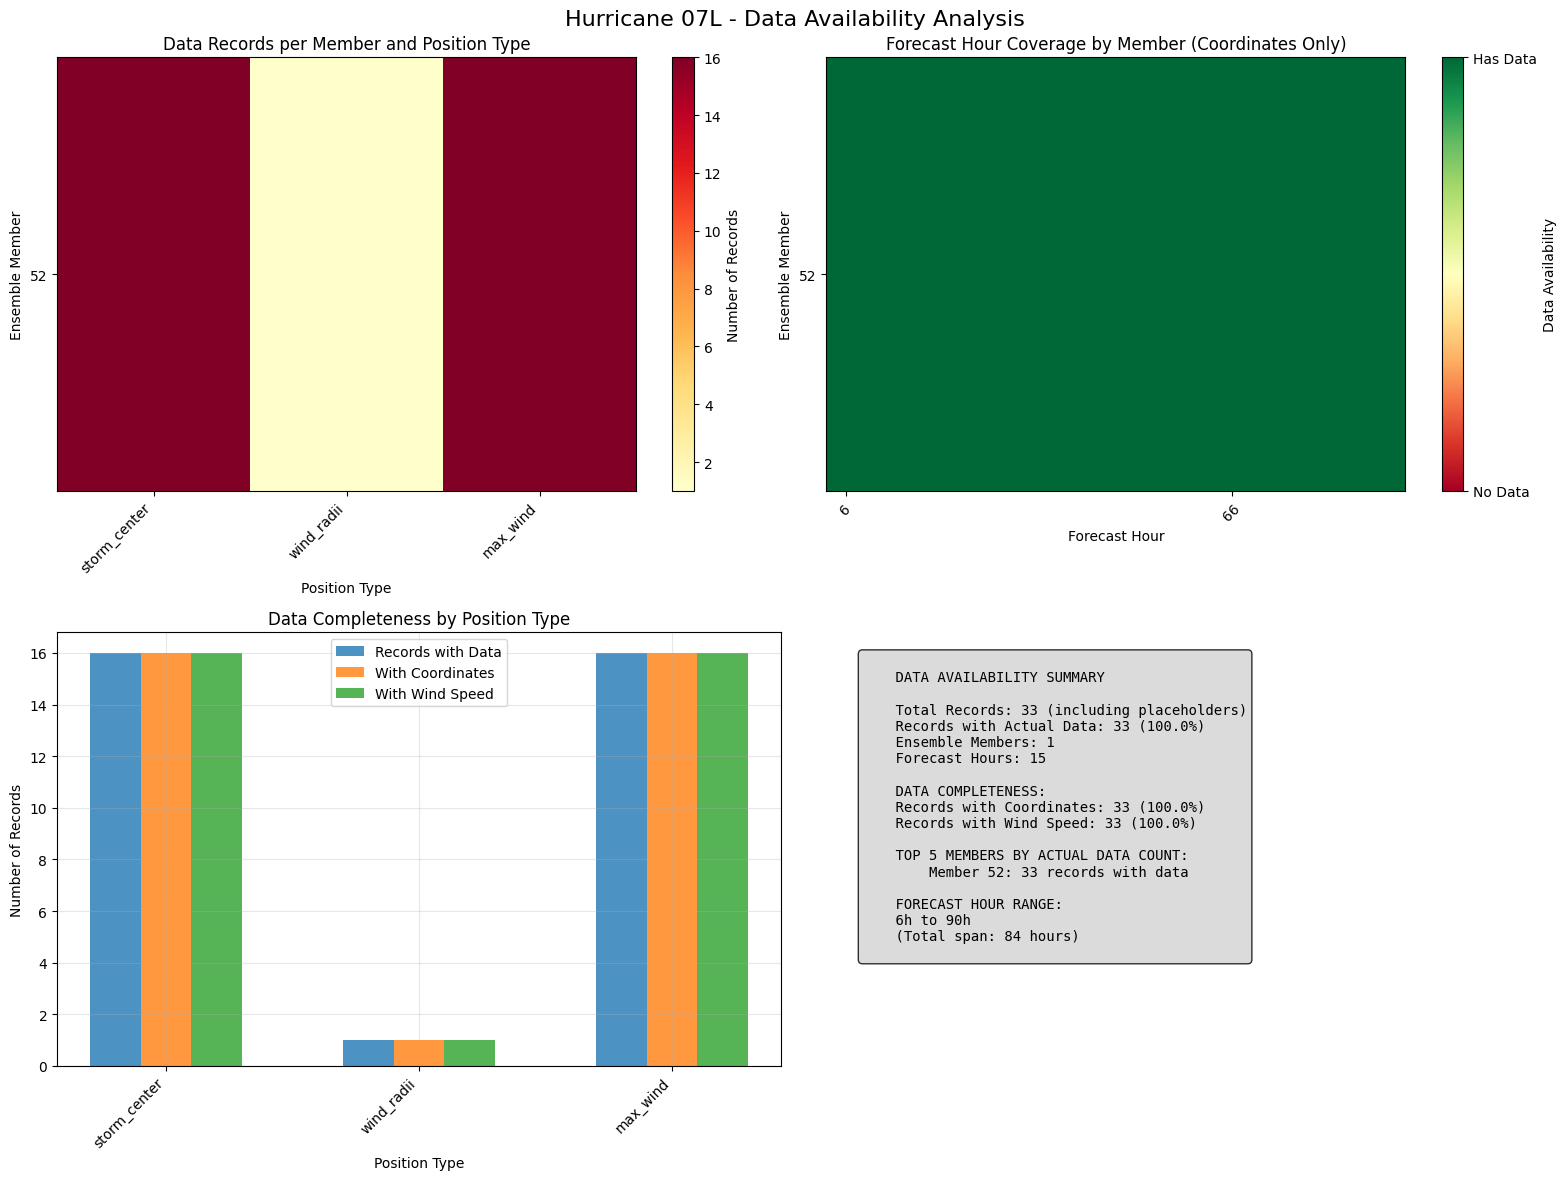

In [26]:
fig_availability = create_data_availability_visualization(df)

### Track visualization

Displaying all 1 ensemble members


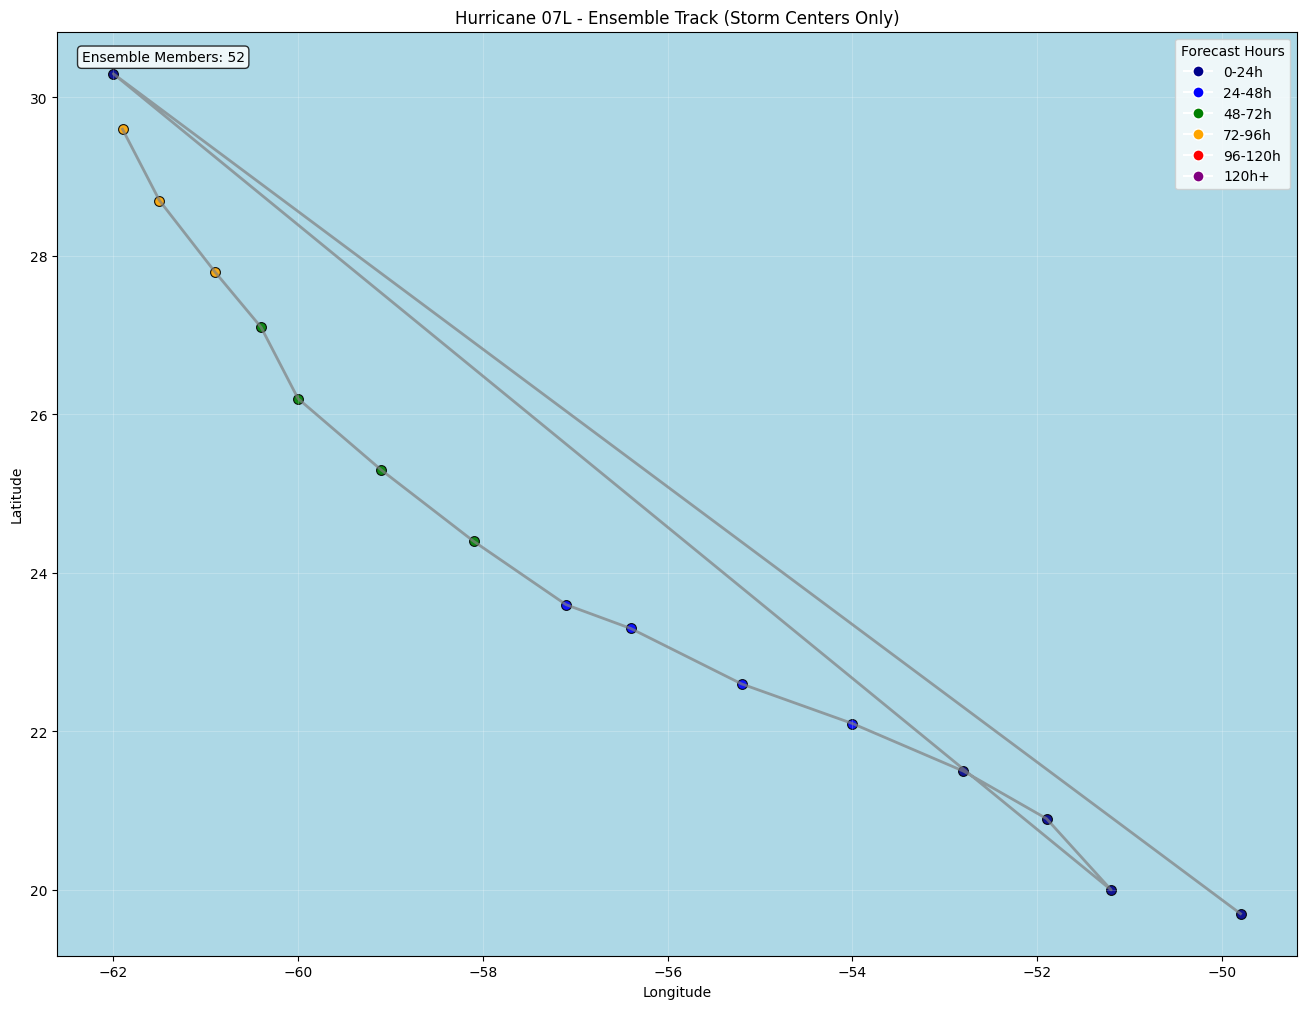

In [27]:
fig_tracks = create_track_visualization(df)

### Wind Fields Visualization

Displaying all 1 ensemble members
  Drawing 33 directional wind swaths...


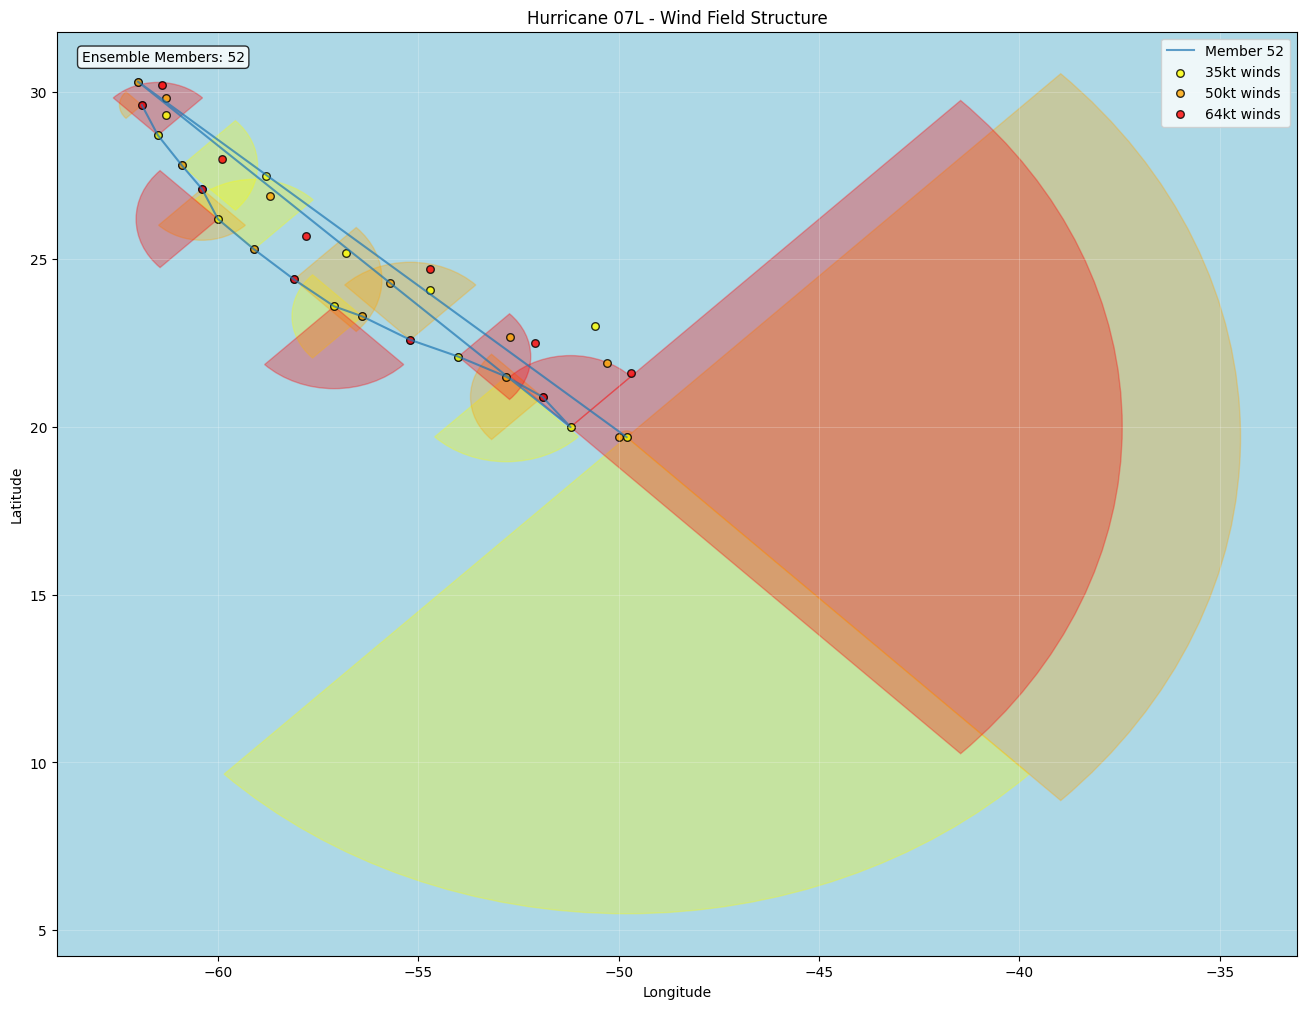

In [28]:
fig_wind_fields = create_wind_field_visualization(df, radii_df)

### Wind Radii Spatial Plot

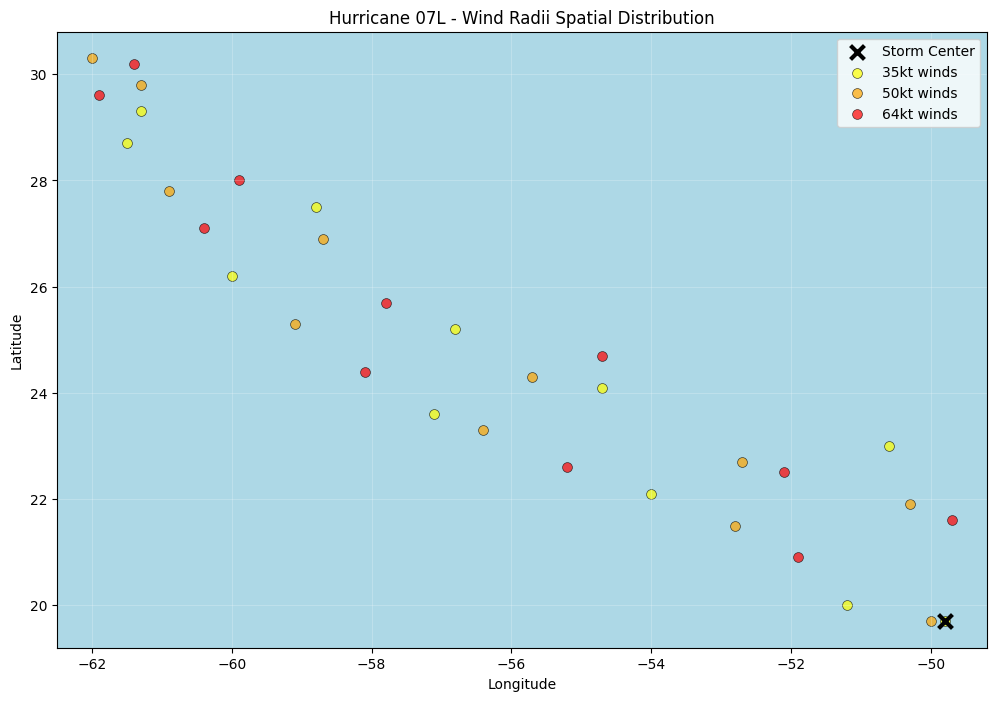

In [29]:
fig_radii_spatial = create_wind_radii_spatial_plot(df, radii_df)

### Wind Radii Direction Plot

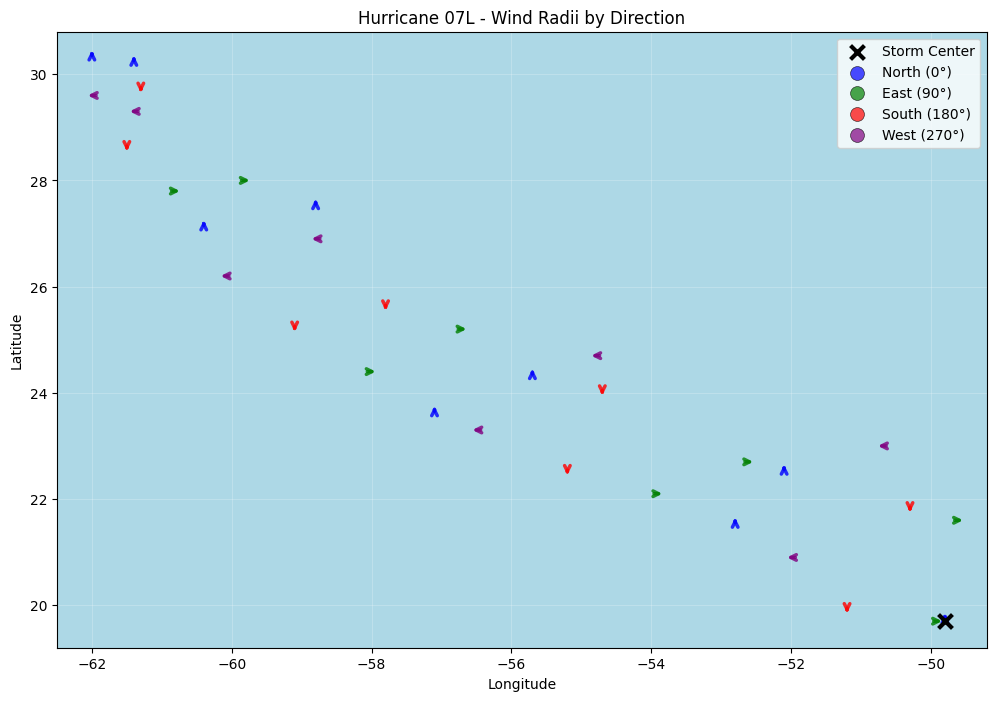

In [30]:
fig_radii_direction = create_wind_radii_direction_plot(df, radii_df)